# Import Libraries

**Originator: Beema Rajan + Zhiqi Zhang +  Shivam Tyagi**

In [63]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import MinMaxScaler

# Data processing

## Loading Everyone's data

**Originator: Beema Rajan + Zhiqi Zhang + Shivam Tyagi**

In [64]:
# Loading Beema's data
b_path = "raw_data/beema/cleaned_data/"
csv_files = [file for file in os.listdir(b_path) if file.endswith(".csv")]
dataframes = {}
for file in csv_files:
    file_path = os.path.join(b_path, file)
    df = pd.read_csv(file_path)
    dataframes[file] = df
    print(f"Loaded '{file}' with {df.shape[0]} rows and {df.shape[1]} columns.")

Loaded 'billboard_200_cleaned.csv' with 14400 rows and 21 columns.
Loaded 'country_airplay_cleaned.csv' with 14754 rows and 13 columns.
Loaded 'country_on-demand_streaming_cleaned.csv' with 14400 rows and 17 columns.
Loaded 'current_country_albums_cleaned.csv' with 5412 rows and 14 columns.
Loaded 'current_pop_albums_cleaned.csv' with 7247 rows and 14 columns.
Loaded 'current_r&b_hip_hop_albums_cleaned.csv' with 14279 rows and 14 columns.
Loaded 'current_rap_albums_cleaned.csv' with 7303 rows and 14 columns.
Loaded 'current_rock_albums_cleaned.csv' with 3602 rows and 14 columns.
Loaded 'dance_electronic_on-demand_cleaned.csv' with 14400 rows and 17 columns.
Loaded 'heatseekers_cleaned.csv' with 10800 rows and 17 columns.
Loaded 'pop_on-demand_streaming_cleaned.csv' with 14400 rows and 17 columns.
Loaded 'r&b_hip_hop_airplay_cleaned.csv' with 14702 rows and 13 columns.
Loaded 'r&b_hip_hop_albums_cleaned.csv' with 202 rows and 14 columns.
Loaded 'r&b_hip_hop_on-demand_streaming_cleaned.c

In [17]:
# Loading Camille's data
c_path = "raw_data/camille/"
csv_files2 = [file for file in os.listdir(c_path) if file.endswith(".csv")]
sentiment_dataframes = {}
for file in csv_files2:
    file_path = os.path.join(c_path, file)
    df = pd.read_csv(file_path)
    sentiment_dataframes[file] = df
    print(f"Loaded '{file}' with {df.shape[0]} rows and {df.shape[1]} columns.")

Loaded 'songs_with_attributes_and_lyrics.csv' with 955320 rows and 17 columns.
Loaded 'songs_with_map.csv' with 177 rows and 176 columns.
Loaded 'spotify_aggregated_by_countries.csv' with 72 rows and 7 columns.
Loaded 'top_spotify_songs.csv' with 7477 rows and 25 columns.
Loaded 'top_spotify_songs_lyrics.csv' with 1440 rows and 27 columns.
Loaded 'universal_top_spotify_songs.csv' with 1475430 rows and 25 columns.


In [13]:
# Loading Shivam's data
s_path = "raw_data/shivam/raw_data/"
csv_files3 = [file for file in os.listdir(s_path) if file.endswith(".csv")]
artists_dataframes = {}
for file in csv_files3:
    file_path = os.path.join(s_path, file)
    df = pd.read_csv(file_path)
    artists_dataframes[file] = df
    print(f"Loaded '{file}' with {df.shape[0]} rows and {df.shape[1]} columns.")

Loaded 'edges.csv' with 300386 rows and 2 columns.
Loaded 'nodes.csv' with 156422 rows and 6 columns.


## Data Preprocessing and Cleaning

### Process data for sentiment analysis

**Originator: Zhiqi Zhang**

In [18]:
#Process data for sentiment analysis
sen_df = sentiment_dataframes['universal_top_spotify_songs.csv']
sen_df['artists_clean'] = sen_df['artists'].str.lower().str.strip()
nodes_df= artists_dataframes['nodes.csv']
nodes_df['name_clean'] = nodes_df['name'].str.lower().str.strip()
merged_df = pd.merge(sen_df,nodes_df,left_on='artists_clean',right_on='name_clean',how='inner')

In [19]:
# Simplify the data
# 1. Remove unnecessary columns
columns_to_drop = ["spotify_id_x", "is_explicit", "duration_ms", "time_signature","artists_clean", "spotify_id_y", "name_y", "name_clean"]
processed_df = merged_df.drop(columns=columns_to_drop)

columns_to_rename = {
    "name_x": "songs",
    "popularity_x": "song_popularity",
    "popularity_y": "artist_popularity"
}
processed_df = processed_df.rename(columns=columns_to_rename)

In [20]:
#2. Remove duplicate columns, keeping only the most recently updated data
processed_df['snapshot_date'] = pd.to_datetime(processed_df['snapshot_date'], errors='coerce')
deduplicated_df = processed_df.sort_values('snapshot_date').drop_duplicates(subset=['songs', 'artists'], keep='last')

print("Deduplicated DataFrame Info:")
print(deduplicated_df.info())

Deduplicated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 7477 entries, 940086 to 0
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   songs               7476 non-null   object        
 1   artists             7476 non-null   object        
 2   daily_rank          7477 non-null   int64         
 3   daily_movement      7477 non-null   int64         
 4   weekly_movement     7477 non-null   int64         
 5   country             7474 non-null   object        
 6   snapshot_date       7477 non-null   datetime64[ns]
 7   song_popularity     7477 non-null   int64         
 8   album_name          7471 non-null   object        
 9   album_release_date  7472 non-null   object        
 10  danceability        7477 non-null   float64       
 11  energy              7477 non-null   float64       
 12  key                 7477 non-null   int64         
 13  loudness            74

In [30]:
# Save the data for analysis to enable repeated use
deduplicated_df.to_csv(os.path.join(c_path,"top_spotify_songs.csv"), index=False)

### Process data for country analysis

**Originator: Zhiqi Zhang**

In [31]:
# Aggregate national data
country_data_filtered = sen_df[['country', 'instrumentalness','liveness','danceability', 'energy', 'valence', 'tempo']]
spotify_aggregated = country_data_filtered.groupby('country').mean().reset_index()
spotify_aggregated.to_csv(os.path.join(c_path,"spotify_aggregated_by_countries.csv"), index=False)

In [36]:
# Load the world map data
map_file_path = os.path.join(c_path,"ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world = gpd.read_file(map_file_path)

In [37]:
# Match the national coverage data with the map data
country_codes_list = spotify_aggregated['country'].unique().tolist()
print("Spotify Aggregated Country Codes List:")
print(country_codes_list)
country_codes_list2 = world['SOV_A3'].unique().tolist()
print(country_codes_list2)

Spotify Aggregated Country Codes List:
['AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR', 'BY', 'CA', 'CH', 'CL', 'CO', 'CR', 'CZ', 'DE', 'DK', 'DO', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JP', 'KR', 'KZ', 'LT', 'LU', 'LV', 'MA', 'MX', 'MY', 'NG', 'NI', 'NL', 'NO', 'NZ', 'PA', 'PE', 'PH', 'PK', 'PL', 'PT', 'PY', 'RO', 'SA', 'SE', 'SG', 'SK', 'SV', 'TH', 'TR', 'TW', 'UA', 'US', 'UY', 'VE', 'VN', 'ZA']
['FJI', 'TZA', 'SAH', 'CAN', 'US1', 'KA1', 'UZB', 'PNG', 'IDN', 'ARG', 'CHL', 'COD', 'SOM', 'KEN', 'SDN', 'TCD', 'HTI', 'DOM', 'RUS', 'BHS', 'GB1', 'NOR', 'DN1', 'FR1', 'TLS', 'ZAF', 'LSO', 'MEX', 'URY', 'BRA', 'BOL', 'PER', 'COL', 'PAN', 'CRI', 'NIC', 'HND', 'SLV', 'GTM', 'BLZ', 'VEN', 'GUY', 'SUR', 'ECU', 'JAM', 'CU1', 'ZWE', 'BWA', 'NAM', 'SEN', 'MLI', 'MRT', 'BEN', 'NER', 'NGA', 'CMR', 'TGO', 'GHA', 'CIV', 'GIN', 'GNB', 'LBR', 'SLE', 'BFA', 'CAF', 'COG', 'GAB', 'GNQ', 'ZMB', 'MWI', 'MOZ', 'SWZ', 'AGO', 'BDI', 'IS1', 'L

In [38]:
country_code_mapping = {
    'AE': 'ARE',  # United Arab Emirates
    'AR': 'ARG',  # Argentina
    'AT': 'AUT',  # Austria
    'AU': 'AUS',  # Australia
    'BE': 'BEL',  # Belgium
    'BG': 'BGR',  # Bulgaria
    'BO': 'BOL',  # Bolivia
    'BR': 'BRA',  # Brazil
    'BY': 'BLR',  # Belarus
    'CA': 'CAN',  # Canada
    'CH': 'CHE',  # Switzerland
    'CL': 'CHL',  # Chile
    'CO': 'COL',  # Colombia
    'CR': 'CRI',  # Costa Rica
    'CZ': 'CZE',  # Czech Republic
    'DE': 'DEU',  # Germany
    'DK': 'DNK',  # Denmark
    'DO': 'DOM',  # Dominican Republic
    'EC': 'ECU',  # Ecuador
    'EE': 'EST',  # Estonia
    'EG': 'EGY',  # Egypt
    'ES': 'ESP',  # Spain
    'FI': 'FIN',  # Finland
    'FR': 'FRA',  # France
    'GB': 'GBR',  # United Kingdom
    'GR': 'GRC',  # Greece
    'GT': 'GTM',  # Guatemala
    'HK': 'HKG',  # Hong Kong
    'HN': 'HND',  # Honduras
    'HU': 'HUN',  # Hungary
    'ID': 'IDN',  # Indonesia
    'IE': 'IRL',  # Ireland
    'IL': 'ISR',  # Israel
    'IN': 'IND',  # India
    'IS': 'ISL',  # Iceland
    'IT': 'ITA',  # Italy
    'JP': 'JPN',  # Japan
    'KR': 'KOR',  # South Korea
    'KZ': 'KAZ',  # Kazakhstan
    'LT': 'LTU',  # Lithuania
    'LU': 'LUX',  # Luxembourg
    'LV': 'LVA',  # Latvia
    'MA': 'MAR',  # Morocco
    'MX': 'MEX',  # Mexico
    'MY': 'MYS',  # Malaysia
    'NG': 'NGA',  # Nigeria
    'NI': 'NIC',  # Nicaragua
    'NL': 'NLD',  # Netherlands
    'NO': 'NOR',  # Norway
    'NZ': 'NZL',  # New Zealand
    'PA': 'PAN',  # Panama
    'PE': 'PER',  # Peru
    'PH': 'PHL',  # Philippines
    'PK': 'PAK',  # Pakistan
    'PL': 'POL',  # Poland
    'PT': 'PRT',  # Portugal
    'PY': 'PRY',  # Paraguay
    'RO': 'ROU',  # Romania
    'SA': 'SAU',  # Saudi Arabia
    'SE': 'SWE',  # Sweden
    'SG': 'SGP',  # Singapore
    'SK': 'SVK',  # Slovakia
    'SV': 'SLV',  # El Salvador
    'TH': 'THA',  # Thailand
    'TR': 'TUR',  # Turkey
    'TW': 'TWN',  # Taiwan
    'UA': 'UKR',  # Ukraine
    'US': 'USA',  # United States
    'UY': 'URY',  # Uruguay
    'VE': 'VEN',  # Venezuela
    'VN': 'VNM',  # Vietnam
    'ZA': 'ZAF',  # South Africa
}


spotify_aggregated['country'] = spotify_aggregated['country'].map(country_code_mapping)

unmapped_countries = spotify_aggregated[spotify_aggregated['country'].isna()]
print("Unmapped countries after mapping:", unmapped_countries)

Unmapped countries after mapping: Empty DataFrame
Columns: [country, instrumentalness, liveness, danceability, energy, valence, tempo]
Index: []


In [39]:
world_merged = world.merge(spotify_aggregated, how='left', left_on='ISO_A3', right_on='country')
world_merged.to_csv(os.path.join(c_path, "songs_with_map.csv"))

### Process data for lyrics analysis

**Originator: Zhiqi Zhang**

In [24]:
lyrics_df = sentiment_dataframes['songs_with_attributes_and_lyrics.csv']
lyrics_df2 = lyrics_df[['name','artists','lyrics']]
lyrics = pd.merge(deduplicated_df,lyrics_df2,left_on=['songs','artists'],right_on=['name','artists'],how='inner')
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   songs               1438 non-null   object        
 1   artists             1438 non-null   object        
 2   daily_rank          1440 non-null   int64         
 3   daily_movement      1440 non-null   int64         
 4   weekly_movement     1440 non-null   int64         
 5   country             1440 non-null   object        
 6   snapshot_date       1440 non-null   datetime64[ns]
 7   song_popularity     1440 non-null   int64         
 8   album_name          1437 non-null   object        
 9   album_release_date  1437 non-null   object        
 10  danceability        1440 non-null   float64       
 11  energy              1440 non-null   float64       
 12  key                 1440 non-null   int64         
 13  loudness            1440 non-null   float64     

In [25]:
lyrics.to_csv(os.path.join(c_path,"top_spotify_songs_lyrics.csv"), index=False)

### Process data for Songs that Stay on the Charts

**Originator: Beema Rajan**

In [66]:
# Top 200 song consumption
df = dataframes['top_200_song_consumption_cleaned.csv']

# Group by 'Song' and keep the row with the highest 'Weeks On Chart'
unique_songs = df.loc[df.groupby('Song')['Weeks On Chart'].idxmax()]
unique_songs = unique_songs.reset_index(drop=True)

# Top 25% of Weeks on Chart
top_songs = unique_songs[unique_songs['Weeks On Chart'] >= 20]

# Bottom 75% of Weeks on Chart
bottom_songs = unique_songs[unique_songs['Weeks On Chart'] < 20]

# Camille's large dataset
all_songs = deduplicated_df.copy()

# Merge two datasets
merged_dataset_top_25 = pd.merge(top_songs, all_songs, how='inner', left_on='Song', right_on='songs')

# Columns to be used for analysis later
song_features = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]

# **Visualization and analysis**

## Feature distribution of Spotify's hit songs across different countries

**Originator: Zhiqi Zhang**

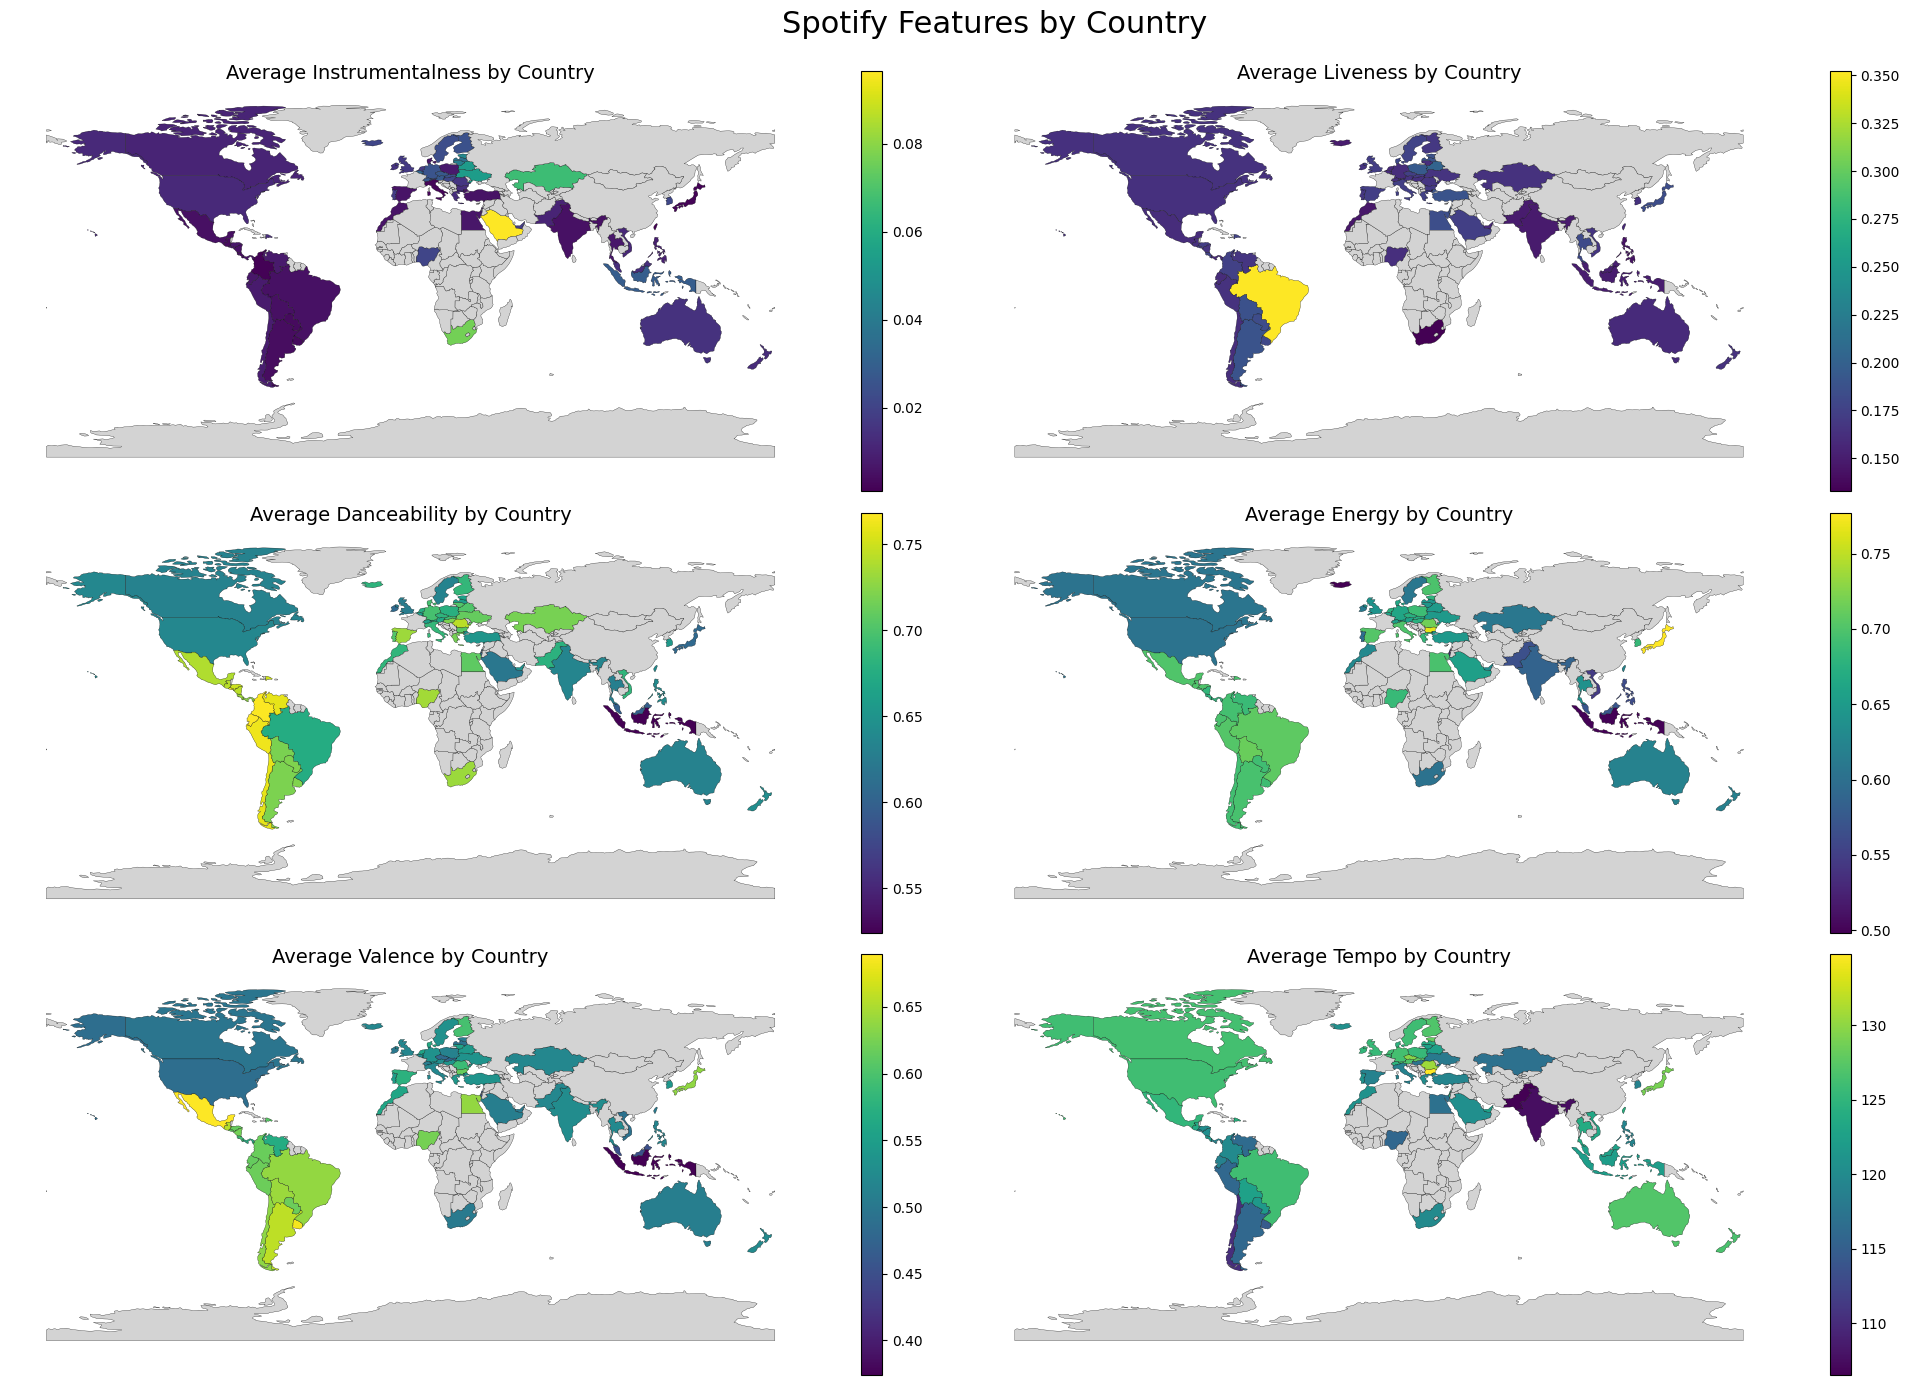

In [45]:
# Define features
features = ['instrumentalness', 'liveness', 'danceability', 'energy', 'valence', 'tempo']

# Create a figure with subplots (3 rows, 2 columns)
fig, ax = plt.subplots(3, 2, figsize=(20, 15))  
fig.suptitle("Spotify Features by Country", fontsize=22, y=0.92)

# Plot each feature
for i, feature in enumerate(features):
    row, col = divmod(i, 2)  # Determine the subplot position
    if feature not in world_merged.columns:
        print(f"Feature '{feature}' not found in merged data.")
        continue

    
    world_merged.plot(
        column=feature,
        cmap="viridis",  
        legend=True,  
        ax=ax[row, col],  
        missing_kwds={"color": "lightgrey", "label": "No data"}, 
        edgecolor="black",  
        linewidth=0.2
    )
    ax[row, col].set_title(f"Average {feature.capitalize()} by Country", fontsize=14)
    ax[row, col].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig("graphs/spotify_features_by_country.png", dpi=300, bbox_inches='tight')
plt.show()

## Relationship between song features and artist popularity

**Originator: Zhiqi Zhang**

In [47]:
# Aggregate the data to analyze the relationship between artist popularity and the characteristics of their hit songs
df = deduplicated_df.copy()
grouped_df = df.groupby("artists").agg({
    "valence": "mean",
    "danceability": "mean",
    "energy": "mean",
    "liveness": "mean",
    "speechiness": "mean",
    "acousticness": "mean",
    "instrumentalness": "mean",
    "tempo": "mean",
    "artist_popularity": "max",
    "followers": "max",
    "songs": "count"
}).reset_index()
grouped_df.rename(columns={"songs": "song_count"}, inplace=True)
print(grouped_df.describe())

           valence  danceability       energy     liveness  speechiness  \
count  2607.000000   2607.000000  2607.000000  2607.000000  2607.000000   
mean      0.541751      0.645517     0.639375     0.183441     0.095572   
std       0.213473      0.132383     0.166642     0.118461     0.088770   
min       0.000010      0.158000     0.001890     0.026800     0.024200   
25%       0.386437      0.563000     0.535192     0.107000     0.037925   
50%       0.530667      0.657000     0.656000     0.145129     0.057600   
75%       0.700000      0.742000     0.758000     0.224817     0.116025   
max       0.992000      0.982000     0.995000     0.964000     0.766000   

       acousticness  instrumentalness        tempo  artist_popularity  \
count   2607.000000       2607.000000  2607.000000        2607.000000   
mean       0.297272          0.020707   123.169721          50.738780   
std        0.241973          0.095909    23.882618          18.883546   
min        0.000013          0.0

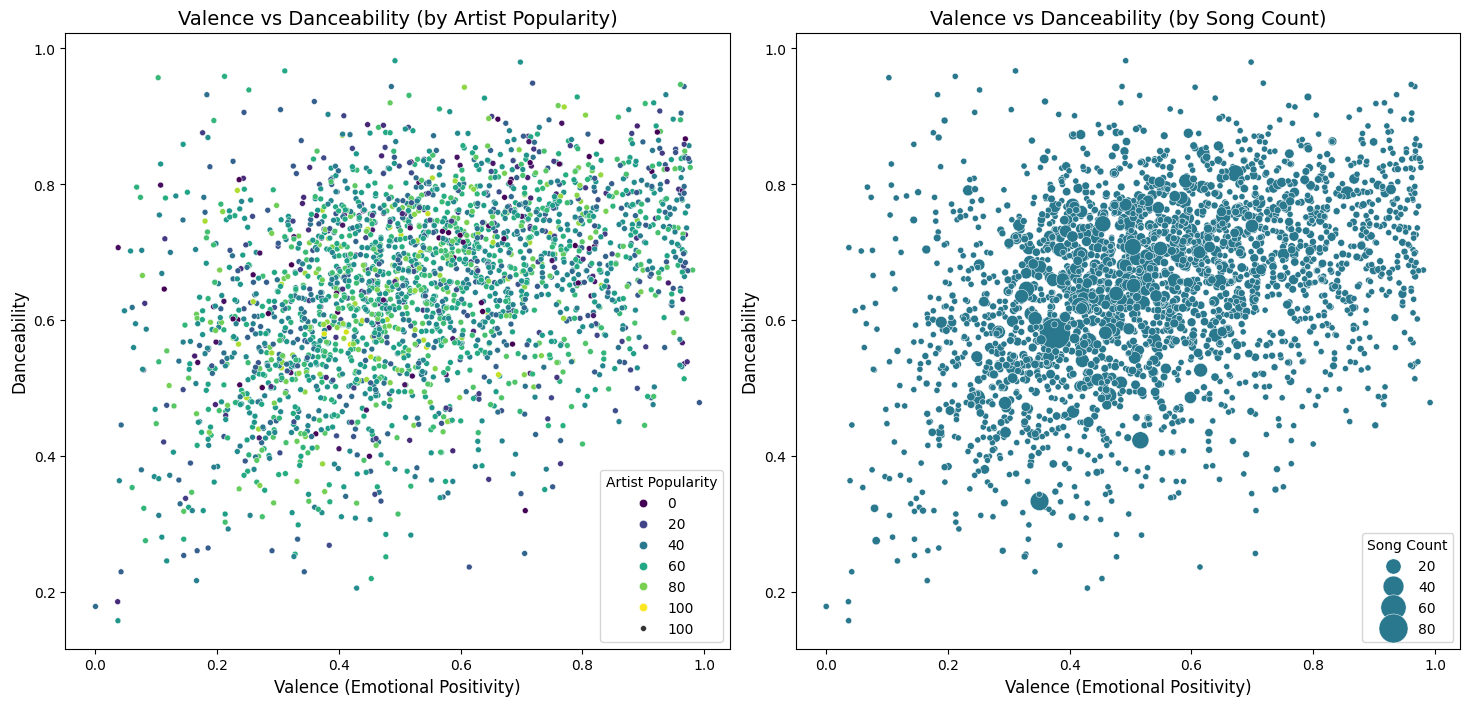

In [59]:
#Visualizing the Relationship Between Valence, Danceability, Artist Popularity, and Song Count
plt.figure(figsize=(18, 8)) 

# Left plot: Color represents artist popularity
plt.subplot(1, 2, 1) 
sns.scatterplot(
    data=grouped_df,
    x="valence", y="danceability",
    hue="artist_popularity", palette="viridis",  # Use color to show artist popularity
    size=100,  # Fix point size
    legend="brief"
)
plt.title("Valence vs Danceability (by Artist Popularity)", fontsize=14) 
plt.xlabel("Valence (Emotional Positivity)", fontsize=12)
plt.ylabel("Danceability", fontsize=12)
plt.legend(title="Artist Popularity", loc="lower right")

# Right plot: Size represents song count
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=grouped_df,
    x="valence", y="danceability",
    size="song_count", sizes=(20, 500),  # Use size to represent song count
    hue=None, color="#2a788e",  # Use a fixed color
    legend="brief"
)
plt.title("Valence vs Danceability (by Song Count)", fontsize=14)
plt.xlabel("Valence (Emotional Positivity)", fontsize=12)
plt.ylabel("Danceability", fontsize=12)
plt.legend(title="Song Count", loc="lower right")  

# Adjust the spacing between plots to avoid overlap
plt.subplots_adjust(wspace=0.1)
plt.savefig("graphs/01_spotify_features_by_artists.png", dpi=300, bbox_inches='tight')
plt.show()

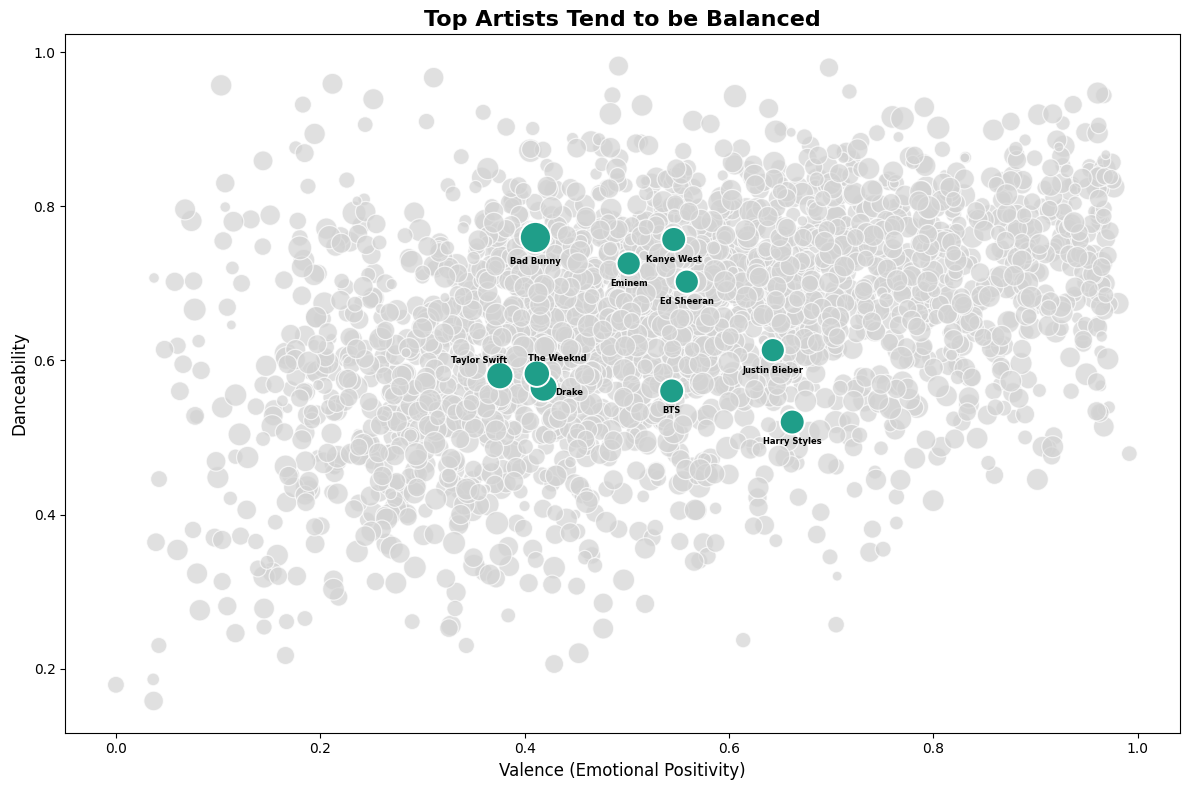

In [62]:
# Get into Depth
top_10_artists = grouped_df.nlargest(10, "artist_popularity")
# Add a new column to identify the top 10 artists
grouped_df["highlight"] = grouped_df["artists"].apply(lambda x: "Top 10" if x in top_10_artists["artists"].values else "Others")

# Plot all points as the base layer
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=grouped_df[grouped_df["highlight"] == "Others"],
    x="valence",
    y="danceability",
    size="artist_popularity",
    sizes=(50, 300),
    color="lightgray",
    alpha=0.7,
    legend=None
)

# Plot the top 10 artists as a highlighted layer
sns.scatterplot(
    data=grouped_df[grouped_df["highlight"] == "Top 10"],
    x="valence",
    y="danceability",
    size="artist_popularity",
    sizes=(300, 500),
    color="#1f9e89", # color from viridis palette
    alpha=1.0,
    legend=None
)

# Annotate the top 10 artists with their names, adjusting positions to avoid overlaps
for _, row in top_10_artists.iterrows():
    # Adjust text position dynamically
    if row["artists"] == "Drake":
        x_offset = 0.025  # Adjust X position
        y_offset = 0  # Adjust Y position
    elif row["artists"] == "Taylor Swift":
        x_offset = -0.02
        y_offset = 0.025
    elif row["artists"] == "The Weeknd":
        x_offset = 0.02
        y_offset = 0.025
    elif row["artists"] == "Bad Bunny":
        x_offset = 0
        y_offset = -0.025
    else:
        x_offset = 0
        y_offset = -0.02  # Default offset for non-overlapping artists
    
    plt.text(
        row["valence"] + x_offset,  # Add X offset
        row["danceability"] + y_offset,  # Add Y offset
        row["artists"],
        fontsize=6,
        weight="bold",
        color="black",
        ha="center",
        va="top"
    )

# Customize plot appearance
plt.title("Top Artists Tend to be Balanced", weight='bold', fontsize=16)
plt.xlabel("Valence (Emotional Positivity)", fontsize=12)
plt.ylabel("Danceability", fontsize=12)
plt.tight_layout()
plt.savefig("graphs/02_spotify_features_by_artists.png", dpi=300, bbox_inches='tight')
plt.show()


## Word Cloud of Hit Songs

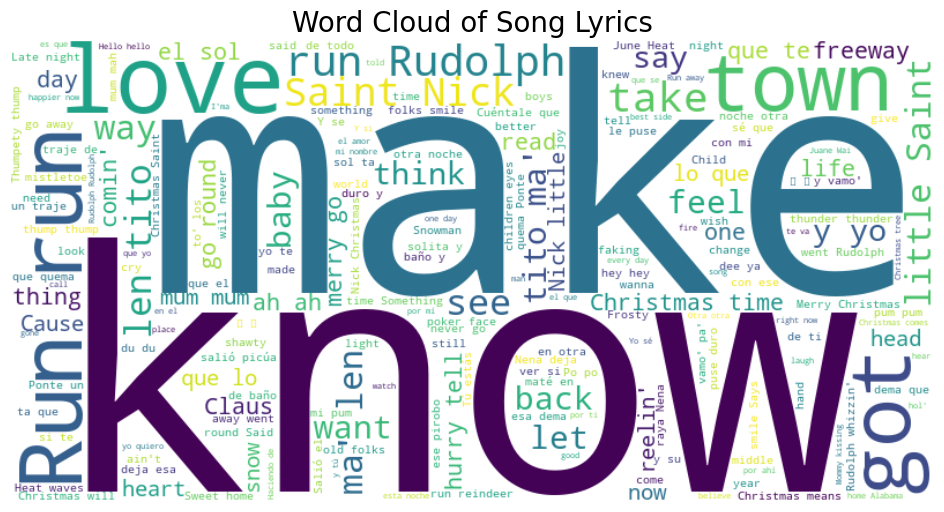

In [61]:
# Define additional stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["oh", "na", "yeah", "ha", "ooh", "gotta", "la", "boy", "girl", "Santa"])

# Combine all lyrics into a single string
lyrics_text = " ".join(lyrics["lyrics"].dropna())

# Create a WordCloud object with custom configurations
wordcloud = WordCloud(
    width=800,          
    height=400,         
    background_color="white",  
    colormap="viridis",  
    max_words=200,      
    stopwords=custom_stopwords      
).generate(lyrics_text)

# Visualize the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")  # Display the word cloud with smooth interpolation
plt.axis("off")
plt.title("Word Cloud of Song Lyrics", fontsize=20)
plt.savefig("graphs/spotify_lyrics_wordcloud.png", dpi=300, bbox_inches='tight')
plt.show()

## Properties of Songs that Stay on the Charts

**Originator: Beema Rajan**

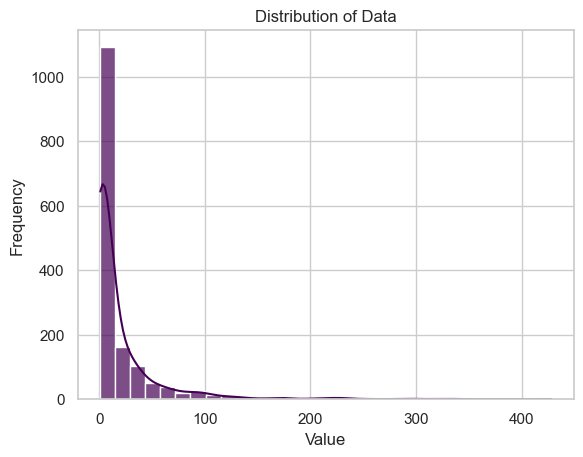

Summary stats:
 count    1543.000000
mean       19.156189
std        38.582145
min         1.000000
25%         1.000000
50%         4.000000
75%        20.000000
max       428.000000
Name: Weeks On Chart, dtype: float64


In [76]:
## Distribution of number of Weeks On Chart

# Data
data = unique_songs['Weeks On Chart']

# Create the plot
# plt.figure(figsize=(16, 8)) # Change if needed
sns.histplot(data, bins=30, kde=True, color='#440154', alpha=0.7)  # kde=True adds a density curve
plt.title('Distribution of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.savefig("graphs/01_properties_of_songs_on_chart.png", dpi=300, bbox_inches='tight')
plt.show()

# Summary stats of distribution
print('Summary stats:\n', data.describe())

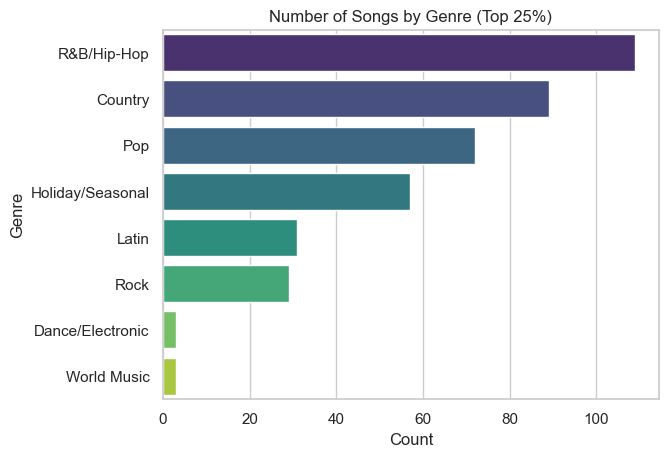

In [77]:
## Count of Genres in the Top 25% of Weeks On Chart

data_genre = top_songs.groupby('Genre')['Song'].count()

# Reset index to convert the Series to a DataFrame
data_genre_df = data_genre.reset_index()
data_genre_df.columns = ['Genre', 'Count']
data_genre_df = data_genre_df.sort_values(by='Count', ascending=False)

# Create the bar plot
sns.barplot(x='Count', y='Genre', data=data_genre_df, hue='Genre', palette='viridis', dodge=False)

# Add title and labels
# plt.figure(figsize=(16, 8)) # Change if needed
plt.title('Number of Songs by Genre (Top 25%)')
plt.xlabel('Count')
plt.ylabel('Genre')

# Show the plot
plt.savefig("graphs/02_properties_of_songs_on_chart.png", dpi=300, bbox_inches='tight')
plt.show()

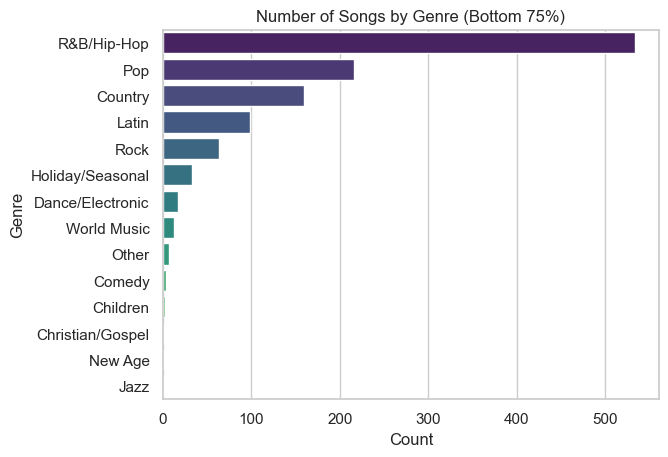

In [78]:
## Count of Genres in the Bottom 75% of Weeks On Chart

data_genre = bottom_songs.groupby('Genre')['Song'].count()

# Reset index to convert the Series to a DataFrame
data_genre_df = data_genre.reset_index()
data_genre_df.columns = ['Genre', 'Count']
data_genre_df = data_genre_df.sort_values(by='Count', ascending=False)

# Create the bar plot
sns.barplot(x='Count', y='Genre', data=data_genre_df, hue='Genre', palette='viridis', dodge=False)

# Add title and labels
# plt.figure(figsize=(16, 8)) # Change if needed
plt.title('Number of Songs by Genre (Bottom 75%)')
plt.xlabel('Count')
plt.ylabel('Genre')

# Show the plot
plt.savefig("graphs/03_properties_of_songs_on_chart.png", dpi=300, bbox_inches='tight')
plt.show()

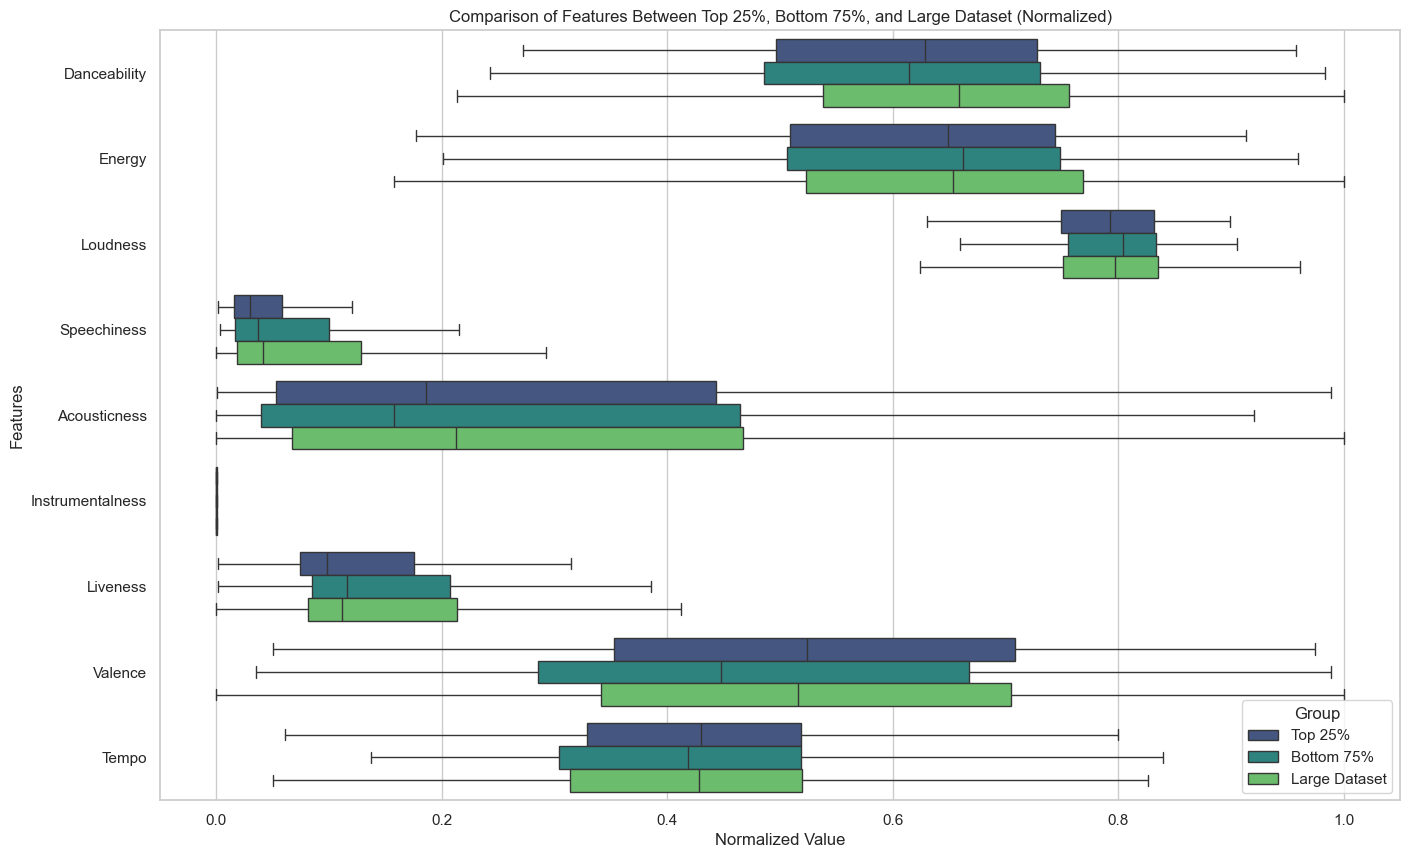

In [79]:
## Similarity of all three sets

# Combine all datasets before normalization
top_songs_merged = merged_dataset_top_25[song_features]
bottom_songs_merged = all_songs.loc[all_songs['songs'].isin(bottom_songs['Song']), song_features]
large_dataset = all_songs[song_features]

# Ensure consistent normalization
all_data = pd.concat([top_songs_merged, bottom_songs_merged, large_dataset])

# Normalize using MinMaxScaler
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(all_data), columns=song_features)

# Split back into respective groups
normalized_top_songs = normalized_data.iloc[:len(top_songs_merged), :].copy()
normalized_bottom_songs = normalized_data.iloc[len(top_songs_merged):len(top_songs_merged) + len(bottom_songs_merged), :].copy()
normalized_large_dataset = normalized_data.iloc[len(top_songs_merged) + len(bottom_songs_merged):, :].copy()

# Melt datasets to make them easier to visualize
top_songs_melted = normalized_top_songs.melt(var_name='Feature', value_name='Value')
bottom_songs_melted = normalized_bottom_songs.melt(var_name='Feature', value_name='Value')
large_dataset_melted = normalized_large_dataset.melt(var_name='Feature', value_name='Value')

# Add a group column
top_songs_melted['Group'] = 'Top 25%'
bottom_songs_melted['Group'] = 'Bottom 75%'
large_dataset_melted['Group'] = 'Large Dataset'

# Combine the datasets
combined_data = pd.concat([top_songs_melted, bottom_songs_melted, large_dataset_melted])

# Capitalize the first letter of each feature
combined_data['Feature'] = combined_data['Feature'].str.capitalize()

# Create box plots
plt.figure(figsize=(16, 10))
sns.boxplot(
    data=combined_data, 
    x='Value', 
    y='Feature', 
    hue='Group',
    showfliers=False, # Remove outliers
    palette='viridis'
)
plt.title(r'Comparison of Features Between Top 25%, Bottom 75%, and Large Dataset (Normalized)')
plt.xlabel('Normalized Value')
plt.ylabel('Features')
plt.savefig("graphs/04_properties_of_songs_on_chart.png", dpi=300, bbox_inches='tight')
plt.show()

## Genres and Total Activity

**Originator: Beema Rajan**

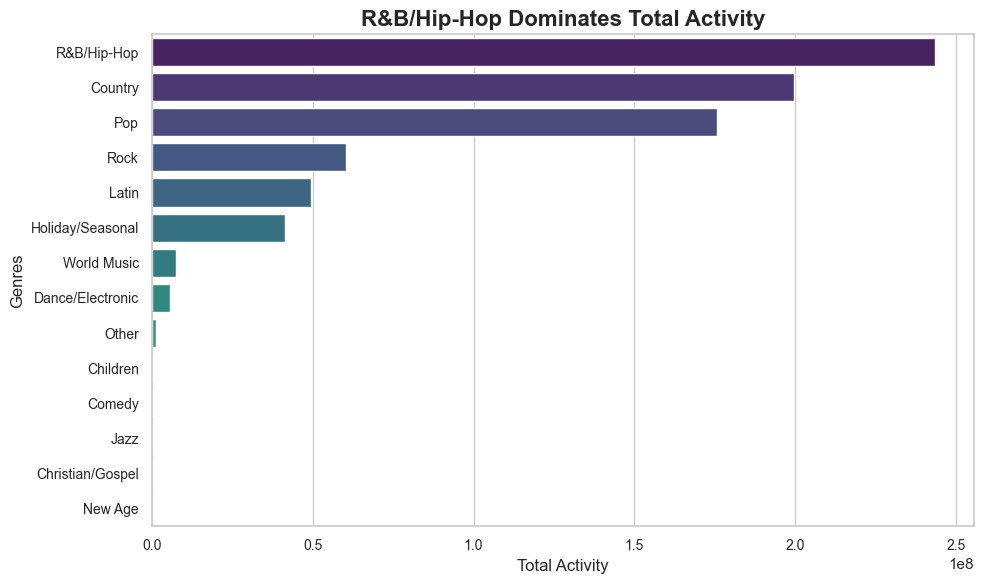

In [81]:
## Bar graph for Genres vs. Total Activity

activity_by_genre = df.groupby('Genre')['TW Total Activity'].sum().sort_values(ascending=False)

# Convert Series to DataFrame for Seaborn
activity_df = activity_by_genre.reset_index()
activity_df.columns = ['Genre', 'Total Activity']

# Seaborn barplot template
def create_bar_chart(data, x_column, y_column, title, x_label, y_label):
    sns.set(style="whitegrid")  # Set the style for the plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    
    # Create the barplot
    sns.barplot(data=data, x=x_column, y=y_column, hue=y_column, palette="viridis")
    
    # Add customizations
    plt.title(title, fontsize=16, weight='bold')  # Set the title
    plt.xlabel(x_label, fontsize=12)  # Set x-axis label
    plt.ylabel(y_label, fontsize=12)  # Set y-axis label
    plt.xticks(fontsize=10)  # Adjust x-axis ticks
    plt.yticks(fontsize=10)  # Adjust y-axis ticks
    plt.tight_layout()  # Adjust layout to fit nicely
    
    # Show the plot
    plt.savefig(f"graphs/01_genres_with_acitivity.png", dpi=300, bbox_inches='tight')
    plt.show()

# Use the template
create_bar_chart(
    data=activity_df,
    x_column='Total Activity',
    y_column='Genre',
    title='R&B/Hip-Hop Dominates Total Activity',
    x_label='Total Activity',
    y_label='Genres'
)

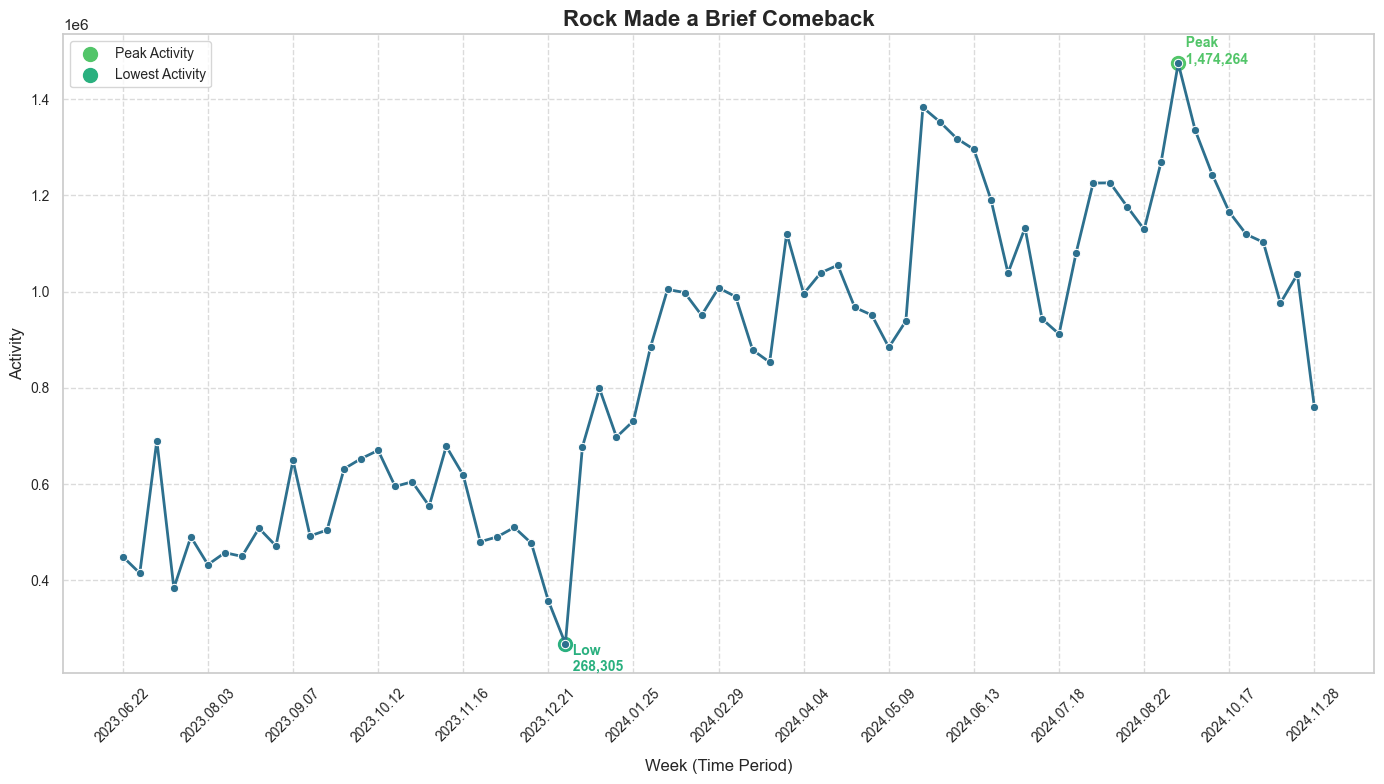

In [82]:
## Line graph for Rock Activity over Time

rock_over_time = df[df['Genre'] == 'Rock'].groupby('week_of')['TW Total Activity'].sum()

# Convert Series to DataFrame for Seaborn
rock_over_time_df = rock_over_time.reset_index()
rock_over_time_df.columns = ['Week', 'Total Activity']

def create_line_graph(data, x_column, y_column, title, x_label, y_label):
    sns.set(style="whitegrid") 
    plt.figure(figsize=(14, 8)) 
    
    # Plot the line graph
    sns.lineplot(
        data=data,
        x=x_column,
        y=y_column,
        marker='o',
        color='#2d708e',
        linewidth=2
    )
    
    # Highlight special points (e.g., peaks and troughs)
    max_point = data[data[y_column] == data[y_column].max()]
    min_point = data[data[y_column] == data[y_column].min()]
    plt.scatter(max_point[x_column], max_point[y_column], color='#52c569', s=100, label='Peak Activity')
    plt.scatter(min_point[x_column], min_point[y_column], color='#2ab07f', s=100, label='Lowest Activity')
    
    # Annotate special points
    for _, row in max_point.iterrows():
        plt.text(row[x_column], row[y_column], f'  Peak\n  {int(row[y_column]):,}', color='#52c569', fontsize=10, weight='bold', ha='left')
    for _, row in min_point.iterrows():
        plt.text(row[x_column], row[y_column], f'  Low\n  {int(row[y_column]):,}', color='#2ab07f', fontsize=10, weight='bold', ha='left', va='top')

    # Optimize x-axis ticks (e.g., show every 5th week)
    tick_step = 5
    ticks = data[x_column][::tick_step]
    plt.xticks(ticks=ticks, labels=ticks, fontsize=10, rotation=45)
    
    # Add customizations
    plt.title(title, fontsize=16, weight='bold')  
    plt.xlabel(x_label, fontsize=12, labelpad=10) 
    plt.ylabel(y_label, fontsize=12)
    plt.xticks(fontsize=10, rotation=45)  
    plt.yticks(fontsize=10)
    
    # Add a legend
    plt.legend(loc='upper left', fontsize=10)
    
    # Add grid and tight layout
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"graphs/02_genres_with_acitivity.png", dpi=300, bbox_inches='tight')
    plt.show()

# Use the updated template
create_line_graph(
    data=rock_over_time_df,
    x_column='Week',
    y_column='Total Activity',
    title='Rock Made a Brief Comeback',
    x_label='Week (Time Period)',
    y_label='Activity'
)

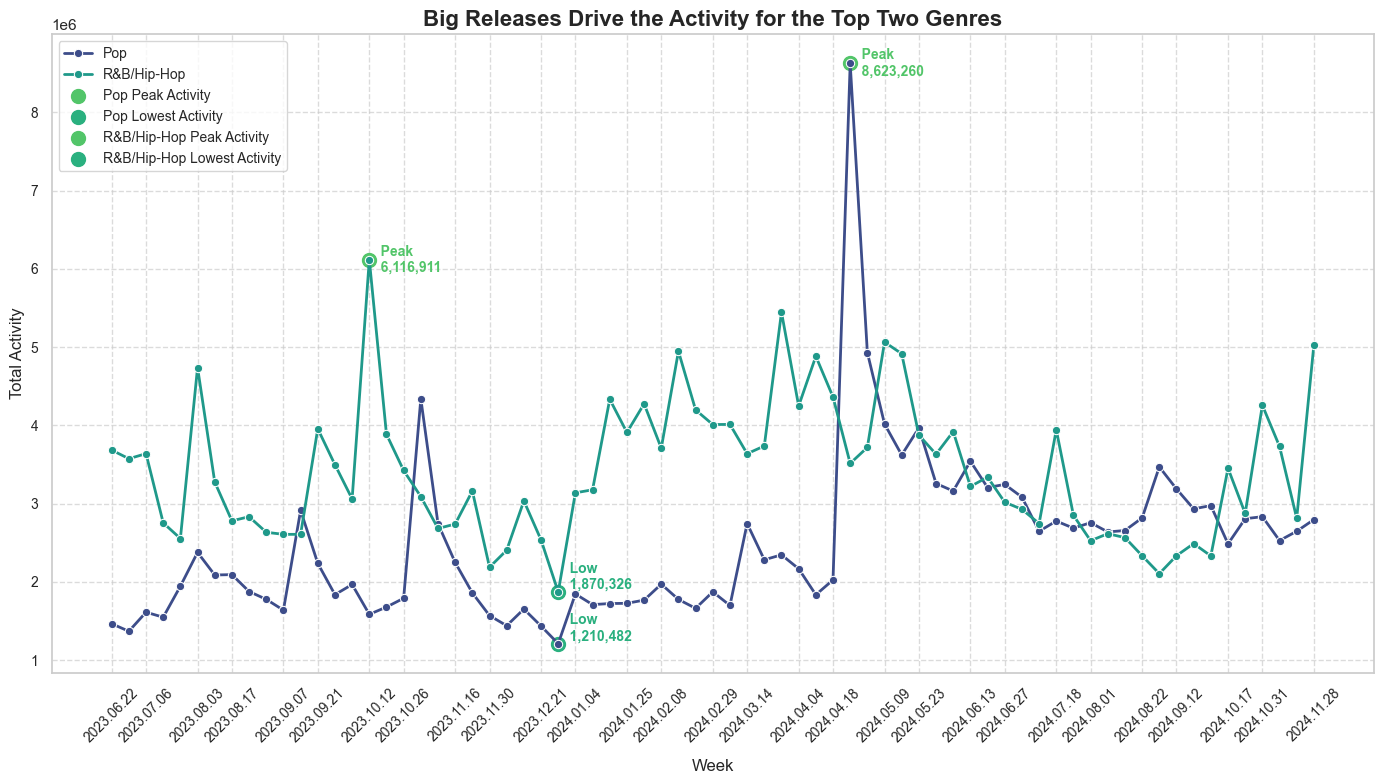

In [83]:
# Group data by week_of and Genre
activity_over_time = df[df['Genre'].isin(['Pop', 'R&B/Hip-Hop'])].groupby(['week_of', 'Genre'])['TW Total Activity'].sum().reset_index()

def create_multi_genre_line_graph(data, x_column, y_column, hue_column, title, x_label, y_label):
    sns.set(style="whitegrid")  
    plt.figure(figsize=(14, 8))  

    # Create the line plot with hue for multiple lines
    sns.lineplot(
        data=data, 
        x=x_column, 
        y=y_column, 
        hue=hue_column, 
        marker='o',
        linewidth=2,
        palette=['#3d4d8a', '#1f998a']
    )

    # Highlight peak and lowest points for each genre
    for genre in data[hue_column].unique():
        genre_data = data[data[hue_column] == genre]
        max_point = genre_data[genre_data[y_column] == genre_data[y_column].max()]
        min_point = genre_data[genre_data[y_column] == genre_data[y_column].min()]
        
        # Scatter points for peak and lowest
        plt.scatter(
            max_point[x_column],
            max_point[y_column],
            color='#52c569',
            s=100,
            label=f'{genre} Peak Activity'
        )
        plt.scatter(
            min_point[x_column],
            min_point[y_column],
            color='#2ab07f',
            s=100,
            label=f'{genre} Lowest Activity'
        )
        
        # Annotate the points
        for _, row in max_point.iterrows():
            plt.text(
                row[x_column], 
                row[y_column], 
                f'   Peak\n   {int(row[y_column]):,}', 
                color='#52c569',
                fontsize=10, 
                weight='bold', 
                ha='left',  # Align text to the left
                va='center',  # Center vertically
                #bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')  # Add a background box
            )
        for _, row in min_point.iterrows():
            plt.text(
                row[x_column], 
                row[y_column], 
                f'   Low\n   {int(row[y_column]):,}', 
                color='#2ab07f', 
                fontsize=10, 
                weight='bold', 
                ha='left',  # Align text to the left
                va='bottom',  # Center vertically
                #bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')  # Add a background box
            )

    # Optimize x-axis ticks (e.g., show every 5th week)
    tick_step = 5
    ticks = data[x_column][::tick_step]
    plt.xticks(ticks=ticks, labels=ticks, fontsize=10, rotation=45)

    # Add customizations
    plt.title(title, fontsize=16, weight='bold')  # Set the title
    plt.xlabel(x_label, fontsize=12, labelpad=10)  # Set x-axis label
    plt.ylabel(y_label, fontsize=12)  # Set y-axis label
    plt.yticks(fontsize=10)  # Adjust y-axis ticks
    plt.legend(loc='upper left', fontsize=10)  # Add legend
    plt.grid(visible=True, linestyle='--', alpha=0.7)  # Add grid
    plt.tight_layout()  # Adjust layout to fit nicely
    
    # Show the plot
    plt.savefig(f"graphs/03_genres_with_acitivity.png", dpi=300, bbox_inches='tight')
    plt.show()

# Use the updated template
create_multi_genre_line_graph(
    data=activity_over_time,
    x_column='week_of',
    y_column='TW Total Activity',
    hue_column='Genre',
    title='Big Releases Drive the Activity for the Top Two Genres',
    x_label='Week',
    y_label='Total Activity'
)